<a href="https://colab.research.google.com/github/a-zapala/MouseCells/blob/main/vae_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
ZIPPED_DATA_PATH = './MouEmbTrkDtb.zip'
UNZIPED_DATA_PATH = './MouEmbTrkDtb'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
!wget http://celltracking.bio.nyu.edu/MouEmbTrkDtb.zip

--2021-01-17 16:56:11--  http://celltracking.bio.nyu.edu/MouEmbTrkDtb.zip
Resolving celltracking.bio.nyu.edu (celltracking.bio.nyu.edu)... 128.122.4.26
Connecting to celltracking.bio.nyu.edu (celltracking.bio.nyu.edu)|128.122.4.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579849355 (3.3G) [application/zip]
Saving to: ‘MouEmbTrkDtb.zip.1’

MouEmbTrkDtb.zip.1    0%[                    ]   8.21M  5.81MB/s               ^C


In [ ]:
!unzip -q {ZIPPED_DATA_PATH}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    UNZIPED_DATA_PATH, 
    target_size=(96, 96),
    batch_size=36,
    color_mode='grayscale',
    subset='training',
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    UNZIPED_DATA_PATH, 
    target_size=(96, 96),
    batch_size=36,
    color_mode='grayscale',
    subset='validation',
    class_mode='categorical')


Found 27346 images belonging to 100 classes.
Found 6787 images belonging to 100 classes.


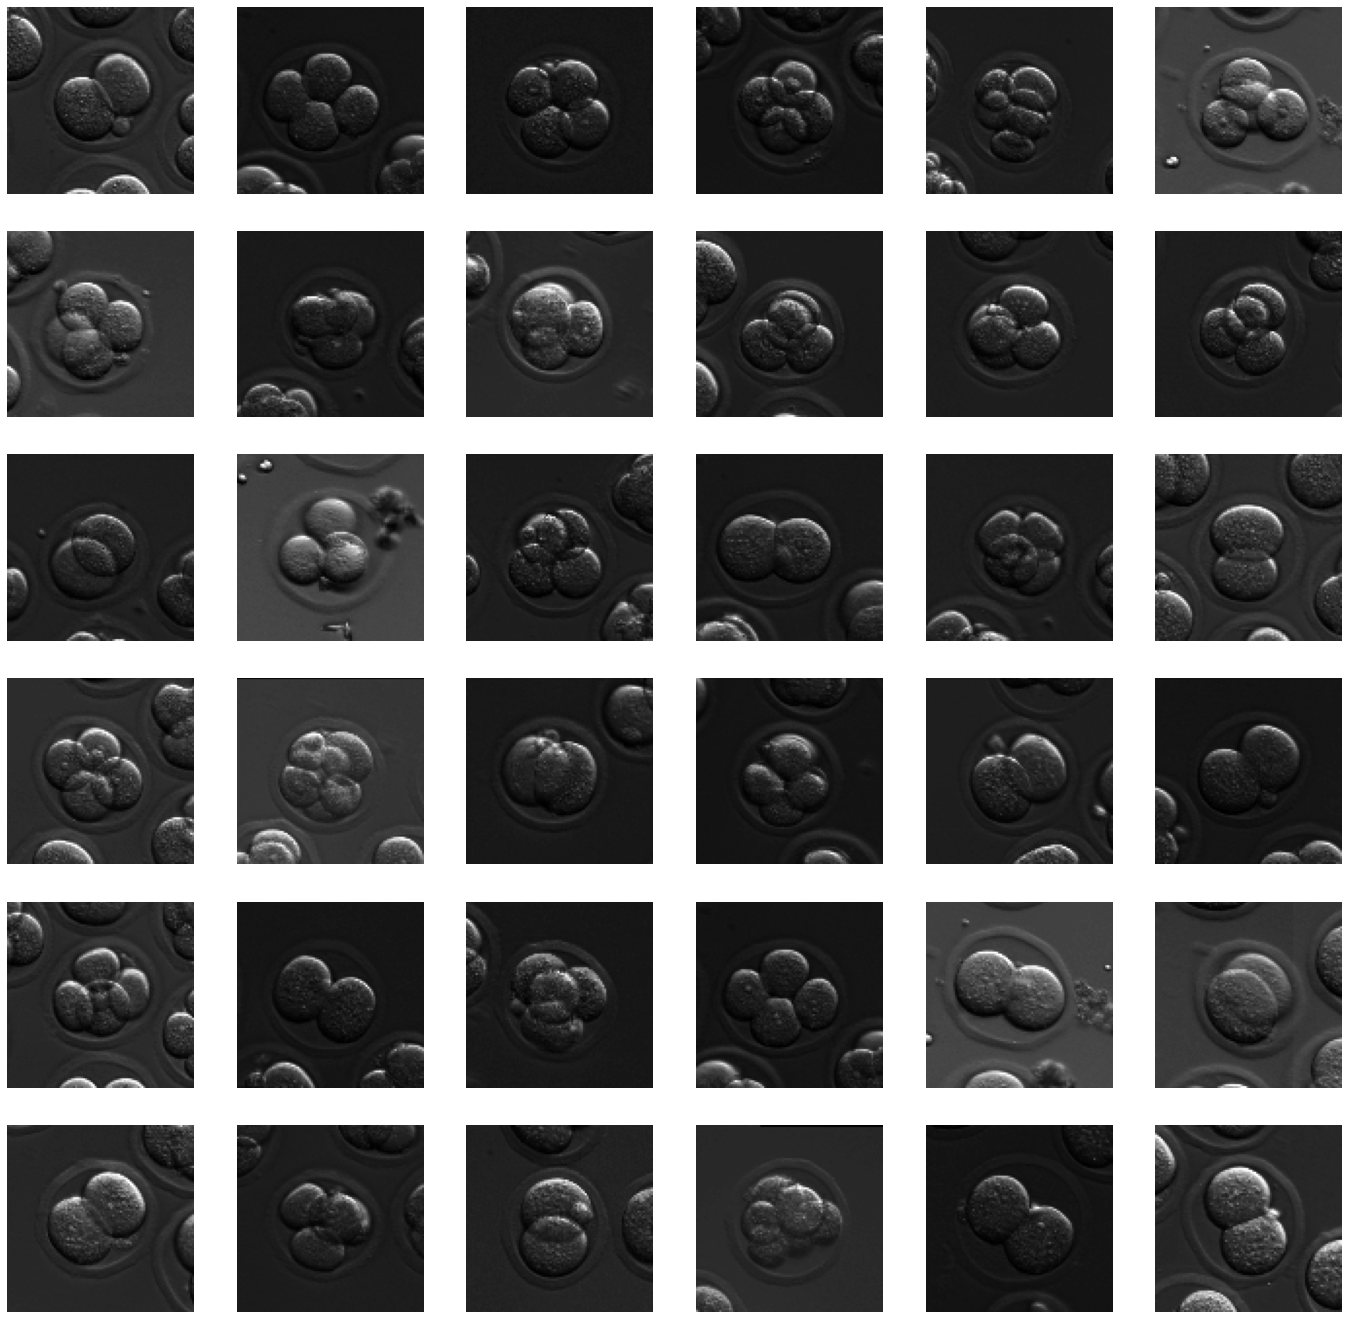

In [ ]:
cols = 6
rows = 6


j = 0

imgs, _ = next(train_generator)

fig = plt.figure(figsize=(4*cols, 4*rows))
for i in range(rows*cols):
    a = fig.add_subplot(rows, cols, i+1)
    a.axis('off')
    a.set_title('')
    a.imshow(np.squeeze(imgs[j], axis=2), cmap='gray')
    j += 1

## Sample Layer


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder


In [ ]:
latent_dim = 100
ef_size = 128

encoder_inputs = keras.Input(shape=(96, 96, 1))

x = layers.Conv2D(ef_size, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(ef_size, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(ef_size * 2, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(ef_size * 2, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)



x = layers.Flatten()(x)
x = layers.Dense(latent_dim * 0.5, activation=layers.LeakyReLU())(x)

z_mean = layers.Dense(latent_dim,  name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 48, 48, 128)  1280        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 48, 48, 128)  512         conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 128)  147584      batch_normalization_10[0][0]     
____________________________________________________________________________________________

## Build the decoder


In [ ]:
df_size = 128

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(6 * 6 * df_size, activation=layers.LeakyReLU())(latent_inputs)
x = layers.Reshape((6, 6, df_size))(x)

x = layers.Conv2DTranspose(df_size * 2, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(df_size, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(df_size, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(df_size, 3, activation=layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4608)              465408    
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 12, 12, 256)       295168    
_________________________________________________________________
batch_normalization_14 (Batc (None, 12, 12, 256)       1024      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 24, 24, 128)       295040    
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 24, 128)       512 

## Define the VAE as a `Model` with a custom `train_step`


In [ ]:
def generate_images(decoder, save=False, path='./generator_cells_vea.png'):
  cols = 6
  rows = 6

  j = 0
  latent_random = np.random.normal(0, scale=1, size=(rows*cols,latent_dim))
  imgs = decoder.predict(latent_random)

  fig = plt.figure(figsize=(4*cols, 4*rows))
  for i in range(rows*cols):
      a = fig.add_subplot(rows, cols, i+1)
      a.axis('off')
      a.imshow(np.squeeze(imgs[j], axis=2), cmap='gray')

      j += 1
  if save:  
    plt.savefig(path)
  else:
    plt.show()

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 96 * 96
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
        
    def call(self, x):
      _, _, x = self.encoder(x)
      return self.decoder(x)

## Train the VAE


In [ ]:
vae = VAE(encoder, decoder)

In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(cells_x, epochs=30, batch_size=64)

Epoch 1/30
390/390 [==============================] - 67s 173ms/step - loss: 4522.4823 - reconstruction_loss: 4518.2054 - kl_loss: 0.4277
Epoch 2/30
390/390 [==============================] - 67s 172ms/step - loss: 4418.3137 - reconstruction_loss: 4411.6061 - kl_loss: 0.6708
Epoch 3/30
390/390 [==============================] - 67s 171ms/step - loss: 4400.2686 - reconstruction_loss: 4392.2080 - kl_loss: 0.8061
Epoch 4/30
390/390 [==============================] - 67s 171ms/step - loss: 4390.2726 - reconstruction_loss: 4381.8729 - kl_loss: 0.8400
Epoch 5/30
390/390 [==============================] - 67s 171ms/step - loss: 4384.1862 - reconstruction_loss: 4375.6731 - kl_loss: 0.8513
Epoch 6/30
390/390 [==============================] - 67s 171ms/step - loss: 4384.8479 - reconstruction_loss: 4376.3025 - kl_loss: 0.8545
Epoch 7/30
390/390 [==============================] - 67s 171ms/step - loss: 4381.7562 - reconstruction_loss: 4373.2548 - kl_loss: 0.8501
Epoch 8/30
390/390 [==============

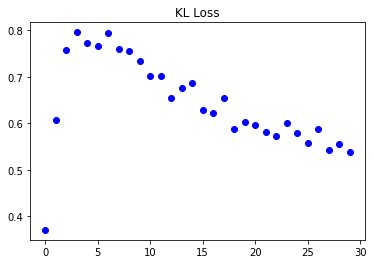

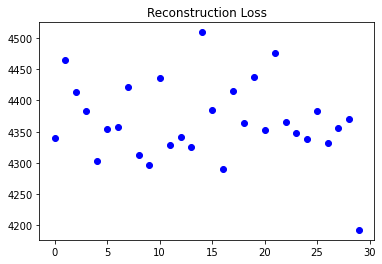

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# get from variable "history"
kl_loss = history.history.get('kl_loss')
rec_loss = history.history.get('reconstruction_loss')


epochs = history.epoch

plt.plot(epochs, kl_loss, 'bo')
plt.title('KL Loss')
plt.figure()

plt.plot(epochs, rec_loss, 'bo')
plt.title('Reconstruction Loss')
plt.figure()

plt.show()

# Test reconstruction

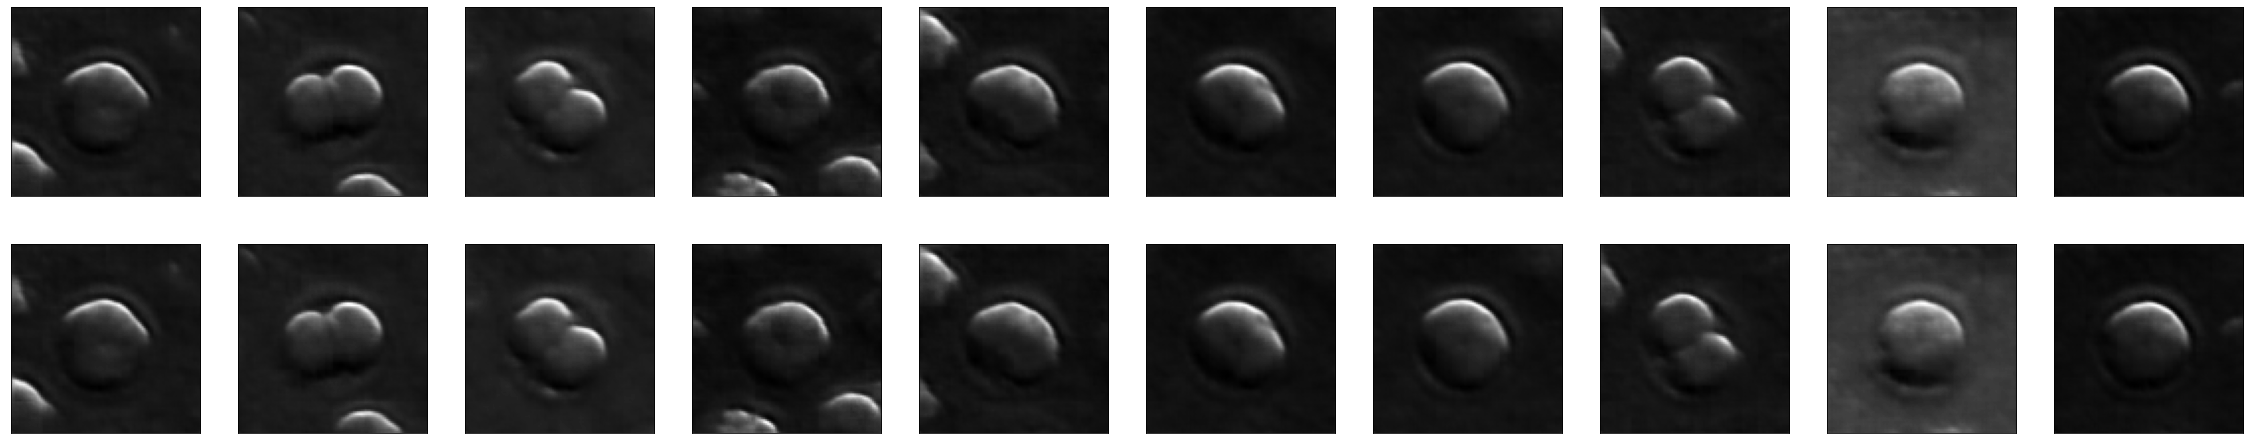

In [ ]:
test_sample, _ = next(test_generator)

_, _, latent_imgs = encoder.predict(test_sample)
decoded_imgs = decoder.predict(latent_imgs)

n = 10  
plt.figure(figsize=(40, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(96, 96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(96, 96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

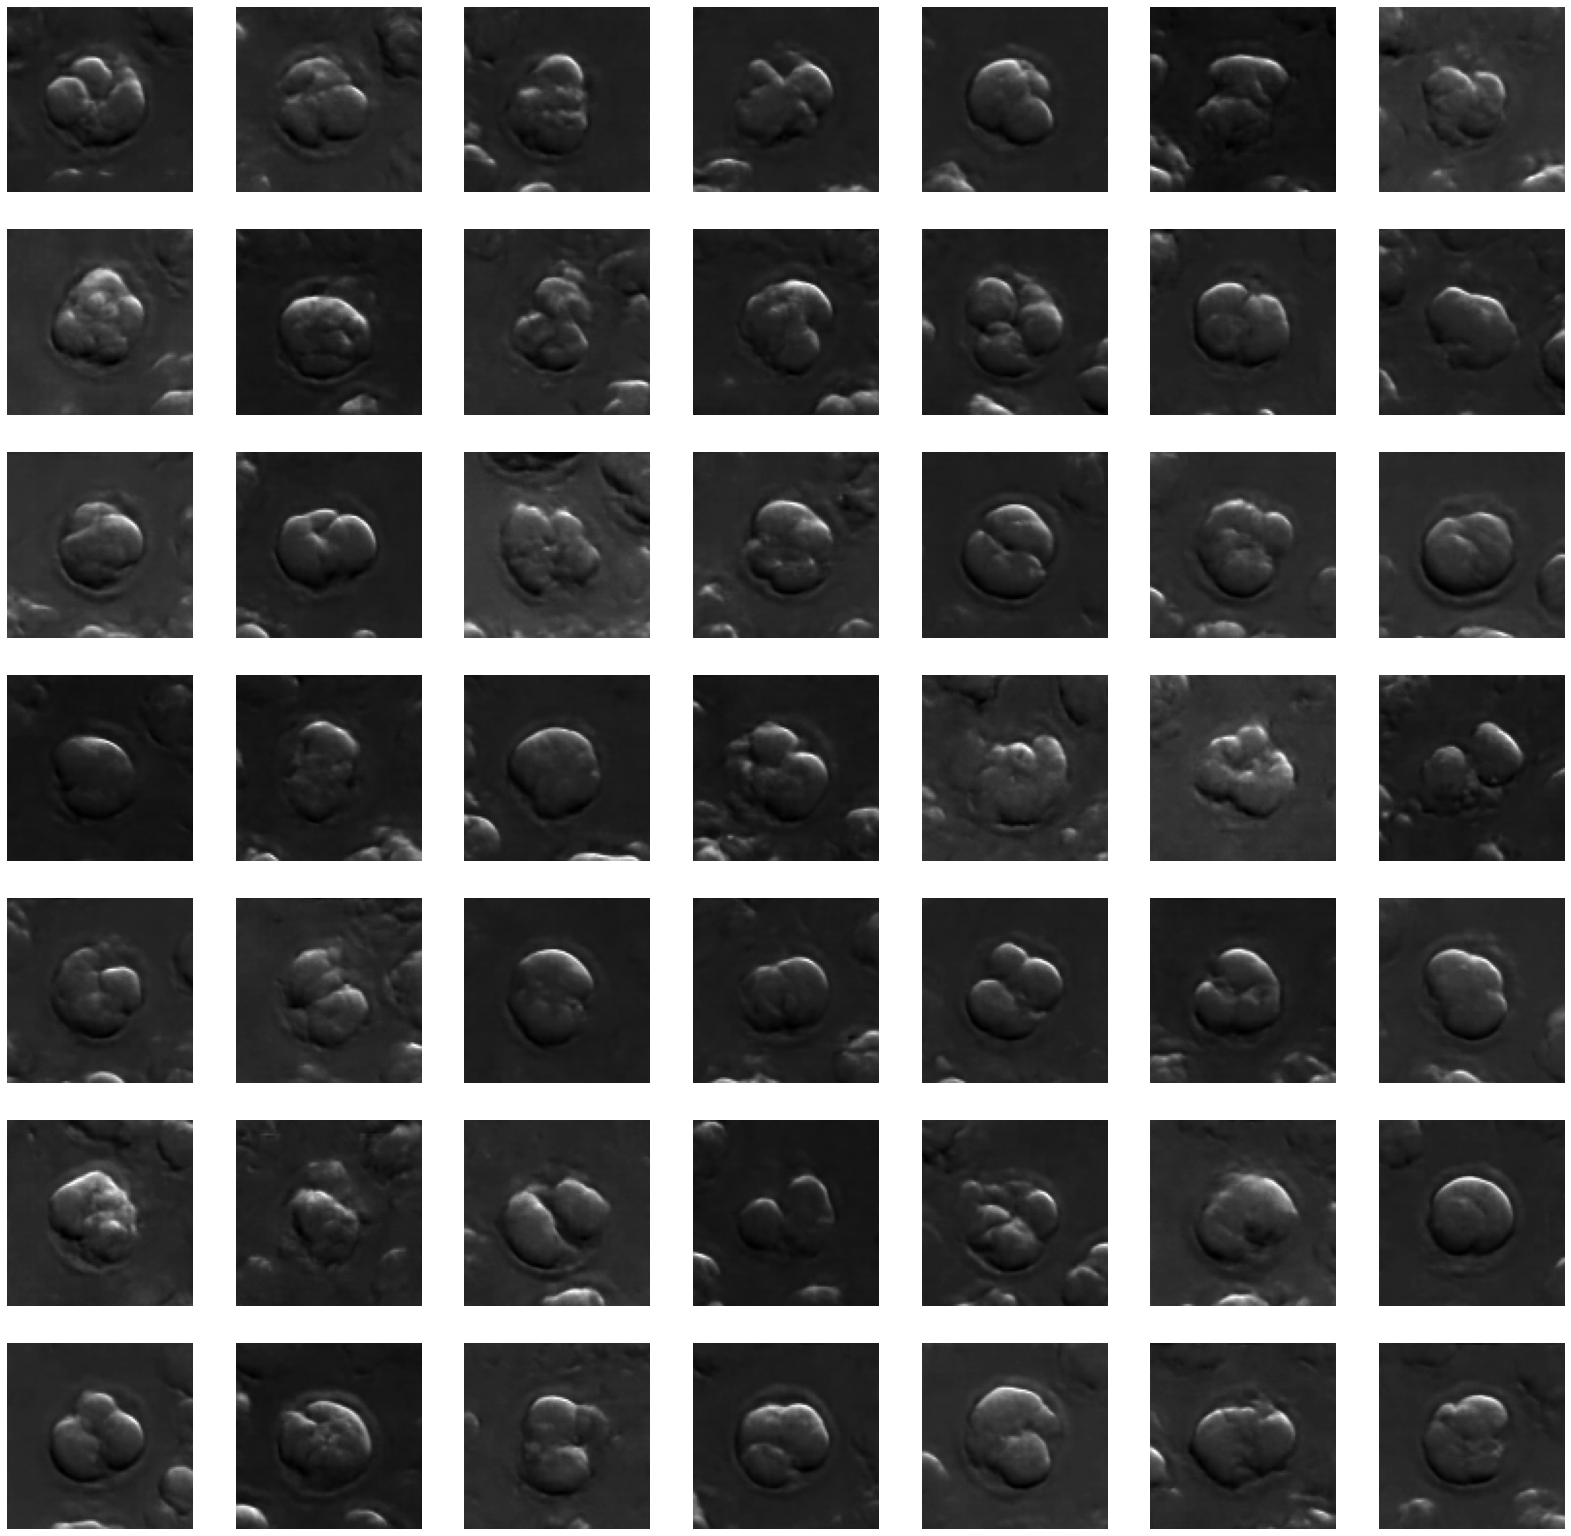

In [ ]:
generate_images(decoder, True)